In [246]:
from math import sqrt, sin, cos, tan, atan2
from scipy.fft import fft
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

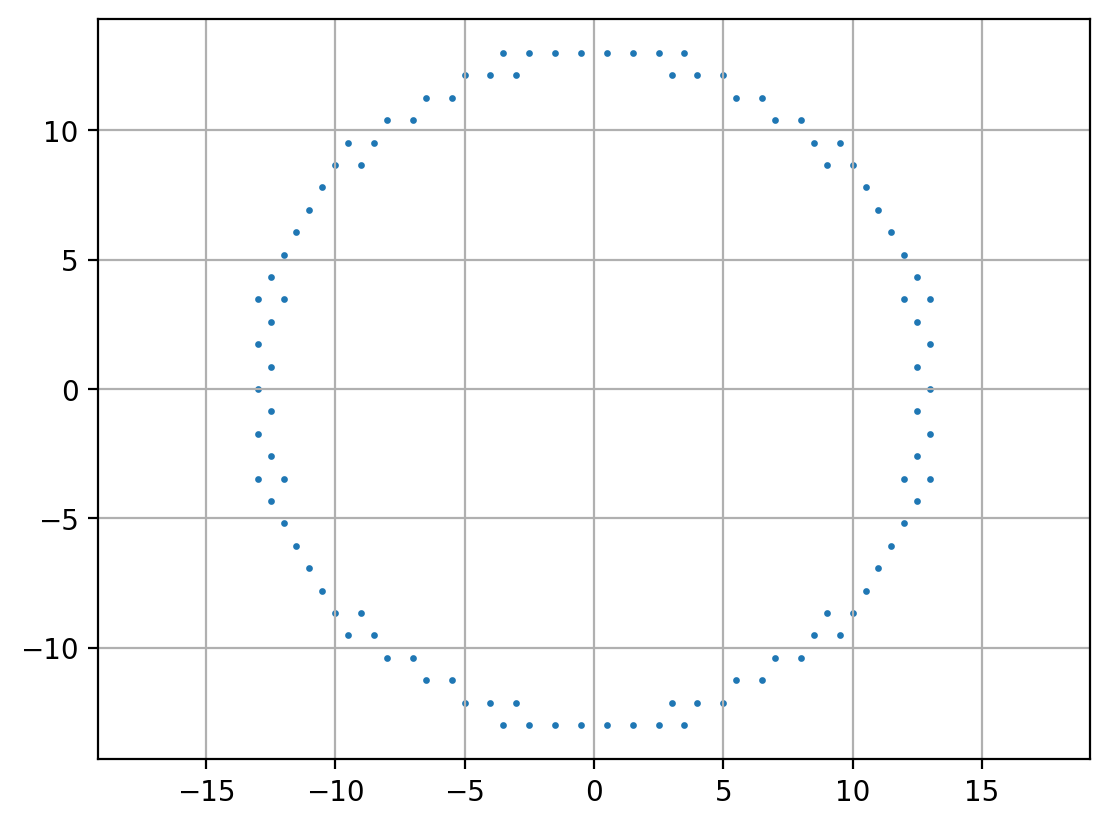

In [247]:
pos_lattice = []
for m in range(-32, 33):
    for n in range(-32, 33):
        if m * m + n * n + m * n in [156, 157, 163, 169, 171, 172, 175, 181]:
            pos_lattice.append((m, n))
pos_lattice = np.array(pos_lattice, dtype=np.int32)

nbSensors = pos_lattice.shape[0]

shear = np.array([[1, 1/2],
                  [0, sqrt(3)/2]])

pos_array = pos_lattice @ shear.T

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# # First subplot
# axes[0].scatter(pos_lattice[:, 0], pos_lattice[:, 1], s=2)
# axes[0].set_title('array sensor positions in integer lattice')
# axes[0].axis('equal')
# axes[0].grid(True)

# # Second subplot
# axes[1].scatter(pos_array[:, 0], pos_array[:, 1], s=2)
# axes[1].set_title('array sensor positions')
# axes[1].axis('equal')
# axes[1].grid(True)

# # Improve layout
# plt.tight_layout()
# plt.show()

plt.scatter(pos_array[:, 0], pos_array[:, 1], s=2)
plt.axis('equal')
plt.grid(True)

In [248]:
pos_lattice_coarray_set = set()
for i in range(nbSensors):
    for j in range(nbSensors):
        pos_lattice_coarray_set.add((pos_lattice[i][0] - pos_lattice[j][0], pos_lattice[i][1] - pos_lattice[j][1]))

pos_lattice_coarray_dict = {}
for elem in pos_lattice_coarray_set: pos_lattice_coarray_dict[elem] = []

for i in range(nbSensors):
    for j in range(nbSensors):
        dist = (pos_lattice[i][0] - pos_lattice[j][0], pos_lattice[i][1] - pos_lattice[j][1])
        pos_lattice_coarray_dict[dist].append((i, j))

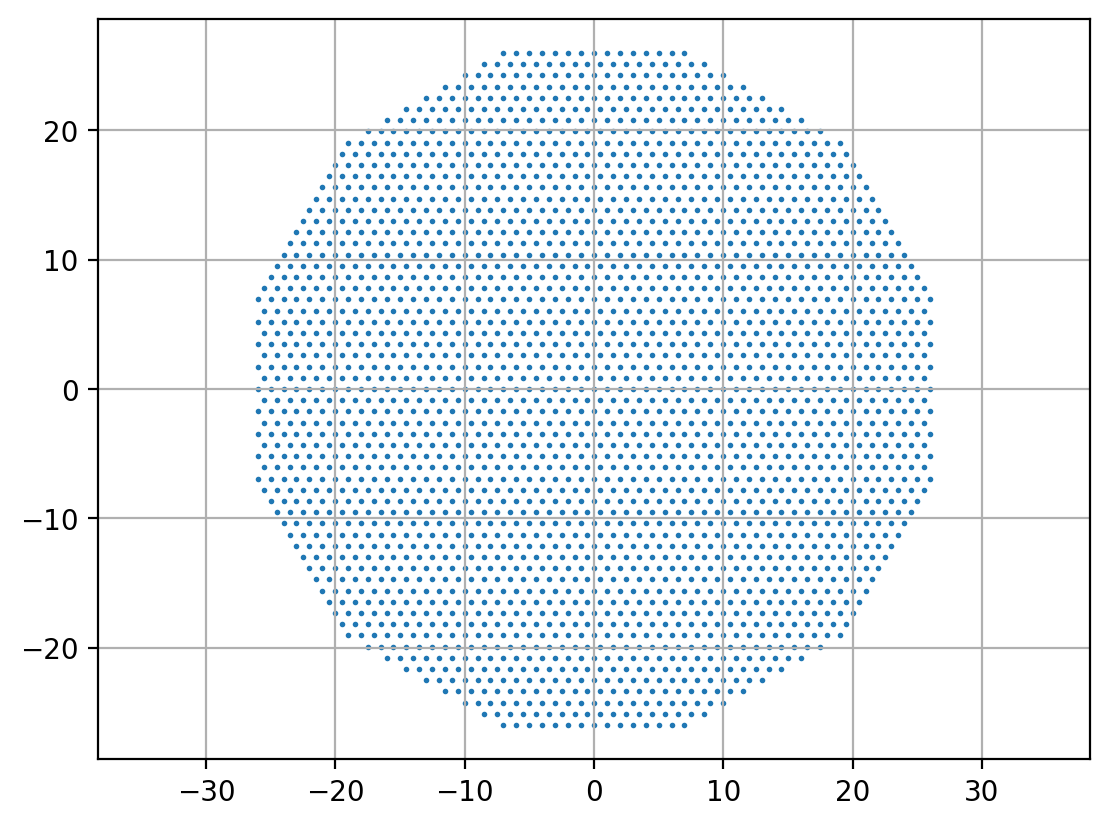

In [249]:
pos_lattice_coarray = np.array(list(pos_lattice_coarray_set), dtype=np.int32)

pos_coarray = pos_lattice_coarray @ shear.T

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# # First subplot
# axes[0].scatter(pos_lattice_coarray[:, 0], pos_lattice_coarray[:, 1], s=1)
# axes[0].set_title('coarray sensor positions in integer lattice')
# axes[0].axis('equal')
# axes[0].grid(True)

# # Second subplot
# axes[1].scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
# axes[1].set_title('coarray sensor positions')
# axes[1].axis('equal')
# axes[1].grid(True)

# # Improve layout
# plt.tight_layout()
# plt.show()

plt.scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
plt.axis('equal')
plt.grid(True)

In [250]:
t = 200
nbSources = 4
snr = 20

theta = np.random.rand(nbSources) * np.pi / 2
phi = np.random.rand(nbSources) * np.pi 
d_lamda_ratio = 1 / 2

A = np.exp(1j * 2 * np.pi * d_lamda_ratio * (pos_array[:, 0].reshape(-1, 1) * (np.sin(theta) * np.cos(phi)).reshape(1, -1) \
                                           + pos_array[:, 1].reshape(-1, 1) * (np.sin(theta) * np.sin(phi)).reshape(1, -1)))
S = (np.random.randn(nbSources, t) + 1j * np.random.randn(nbSources, t)) / sqrt(2)
N = (np.random.randn(nbSensors, t) + 1j * np.random.randn(nbSensors, t)) / sqrt(2) * sqrt(nbSources) * 10 ** (-snr/20)

X = A @ S + N

R = X @ X.T.conj() / t
coarray_covariance = {}

for pos, indices in pos_lattice_coarray_dict.items():
    indices = np.array(indices)
    values = np.mean(R[indices[:, 0], indices[:, 1]])
    coarray_covariance[pos] = values

In [251]:
def get_parallelogram(ex, ey):

    limx, limy, sx, sy, MAX = 0, 0, 0, 0, 1
    
    while (ex[0] * limx, ex[1] * limx) in pos_lattice_coarray_set: limx += 1
    while (ey[0] * limy, ey[1] * limy) in pos_lattice_coarray_set: limy += 1
    
    for x in range(limx):
        for y in range(limy):
            condition = ((ex[0] * x + ey[0] * y, ex[1] * x + ey[1] * y) in pos_lattice_coarray_set) \
                    and ((- ex[0] * x + ey[0] * y, - ex[1] * x + ey[1] * y) in pos_lattice_coarray_set) \
                    and ((ex[0] * x - ey[0] * y, ex[1] * x - ey[1] * y) in pos_lattice_coarray_set) \
                    and ((- ex[0] * x - ey[0] * y, - ex[1] * x - ey[1] * y) in pos_lattice_coarray_set)
            if  condition: 
                if x * y > MAX: 
                    sx, sy, MAX = x, y, x * y
    
    pos_parallelogram = []
    
    for x in range(-sx, sx + 1):
        for y in range(-sy, sy + 1):
            pos_parallelogram.append((ex[0] * x + ey[0] * y, ex[1] * x + ey[1] * y)) 
    
    return pos_parallelogram, sx, sy

def get_fft(pos_parallelogram, sx, sy, n=None):
    cov = [coarray_covariance[idx] for idx in pos_parallelogram]
    cov = np.array(cov).reshape(2 * sy + 1, 2 * sx + 1)
    cov_fft = fft(fft(cov, n=n, axis=0), n=n, axis=1)
    return np.abs(cov_fft)

import numpy as np
from scipy.ndimage import maximum_filter

def find_peaks(matrix, nbPeaks):

    matrix = np.array(matrix)
    neighborhood = maximum_filter(matrix, size=3, mode='constant', cval=-np.inf)
    peaks_mask = (matrix == neighborhood)

    for shift in [(-1,0), (1,0), (0,-1), (0,1)]:
        shifted = np.roll(matrix, shift, axis=(0,1))
        mask = np.ones_like(matrix, dtype=bool)
        if shift[0] == -1:
            mask[0,:] = False
        elif shift[0] == 1:
            mask[-1,:] = False
        if shift[1] == -1:
            mask[:,0] = False
        elif shift[1] == 1:
            mask[:,-1] = False
        peaks_mask &= (matrix > shifted) | ~mask  

    peak_indices = np.argwhere(peaks_mask)
    peak_values = matrix[peaks_mask]
    sorted_indices = np.argsort(-peak_values)
    top_peaks = [(peak_indices[i]) for i in sorted_indices[:nbPeaks]]

    return top_peaks


def arctan2_custom(y, x):
    angle = np.arctan2(y, x)
    angle = np.where(angle < 0, angle + np.pi * 2, angle)
    angle = np.where(angle > np.pi, 2 * np.pi - angle, angle)
    return angle  


def recover_angles_from_peaks(top_peaks, sx, sy, d_lamda_ratio, phi_ref_1, phi_ref_2):

    A = np.array([[cos(phi_ref_1), sin(phi_ref_1)],
                  [cos(phi_ref_2), sin(phi_ref_2)]])
    
    results = []

    for j, i in top_peaks:
        if i <= (2 * sx + 1) * d_lamda_ratio: b1 = - i / (d_lamda_ratio * (2 * sx + 1))
        else: b1 = (1 - i / (2 * sx + 1)) / d_lamda_ratio
        if j <= (2 * sy + 1) * d_lamda_ratio: b2 = - j / (d_lamda_ratio * (2 * sy + 1))
        else: b2 = (1 - j / (2 * sy + 1)) / d_lamda_ratio
        b = np.array([[b1], [b2]])
        x = np.linalg.inv(A) @ b 
        theta = np.arcsin(np.sqrt(x[0, 0] ** 2 + x[1, 0] ** 2))
        phi = arctan2_custom(- x[1, 0], - x[0, 0])
        results.append([theta, phi])
    
    results = np.array(results)

    return results

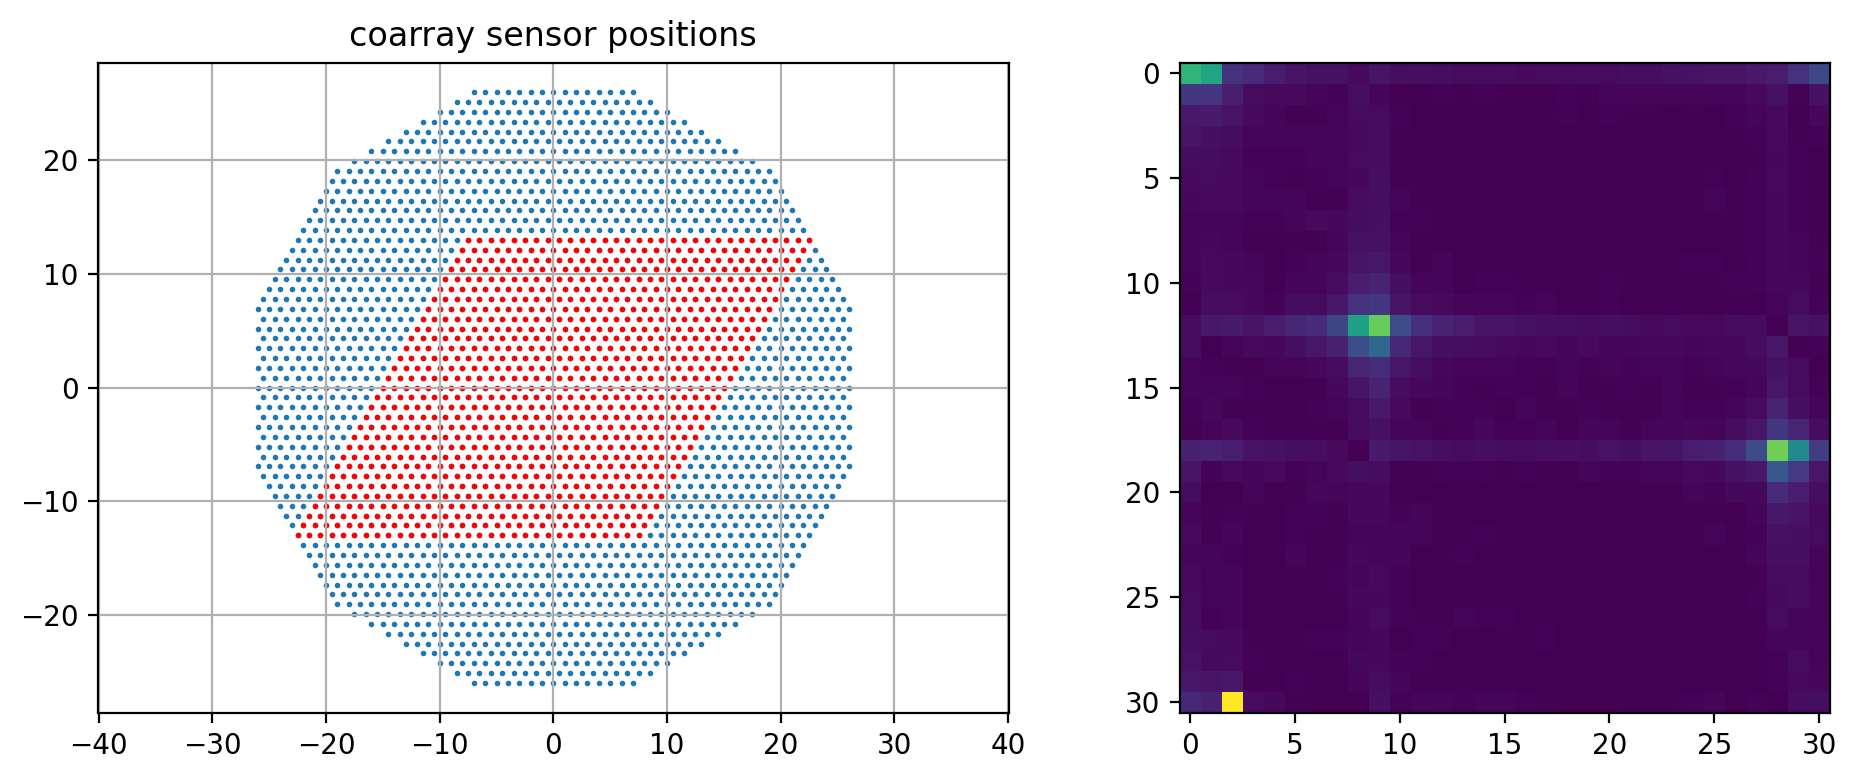

In [252]:
pos_lattice_coarray_set_0_60, sx_0_60, sy_0_60 = get_parallelogram((1, 0), (0, 1))
pos_lattice_coarray_0_60 = np.array(list(pos_lattice_coarray_set_0_60))
pos_coarray_0_60 = pos_lattice_coarray_0_60 @ shear.T

fft_0_60 = get_fft(pos_lattice_coarray_set_0_60, sx_0_60, sy_0_60)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# first subplot
axes[0].scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
axes[0].scatter(pos_coarray_0_60[:, 0], pos_coarray_0_60[:, 1], s=1, color='red')
axes[0].set_title('coarray sensor positions')
axes[0].axis('equal')
axes[0].grid(True)

# second subplot 
axes[1].imshow(fft_0_60)

# Improve layout
plt.tight_layout()
plt.show()

top_peaks_0_60 = find_peaks(fft_0_60, nbPeaks=nbSources)
results_0_60 = recover_angles_from_peaks(top_peaks=top_peaks_0_60, sx=sx_0_60, sy=sy_0_60, d_lamda_ratio=d_lamda_ratio, phi_ref_2=0, phi_ref_1=np.pi/3)

# # First subplot
# axes[0].scatter(pos_lattice_coarray[:, 0], pos_lattice_coarray[:, 1], s=1)
# axes[0].scatter(pos_lattice_coarray_0_60[:, 0], pos_lattice_coarray_0_60[:, 1], s=1, color='red')
# axes[0].set_title('coarray sensor positions in integer lattice')
# axes[0].axis('equal')
# axes[0].grid(True)

# # Second subplot
# axes[1].scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
# axes[1].scatter(pos_coarray_0_60[:, 0], pos_coarray_0_60[:, 1], s=1, color='red')
# axes[1].set_title('coarray sensor positions')
# axes[1].axis('equal')
# axes[1].grid(True)

# # Improve layout
# plt.tight_layout()
# plt.show()

In [253]:
# pos_lattice_coarray_set_0_90, sx_0_90, sy_0_90 = get_parallelogram((1, 0), (-1, 2))
# pos_lattice_coarray_0_90 = np.array(list(pos_lattice_coarray_set_0_90))
# pos_coarray_0_90 = pos_lattice_coarray_0_90 @ shear.T

# fft_0_90 = get_fft(pos_lattice_coarray_set_0_90, sx_0_90, sy_0_90)

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# # first subplot
# axes[0].scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
# axes[0].scatter(pos_coarray_0_90[:, 0], pos_coarray_0_90[:, 1], s=1, color='red')
# axes[0].set_title('coarray sensor positions')
# axes[0].axis('equal')
# axes[0].grid(True)

# # second subplot 
# axes[1].imshow(fft_0_90)

# # Improve layout
# plt.tight_layout()
# plt.show()

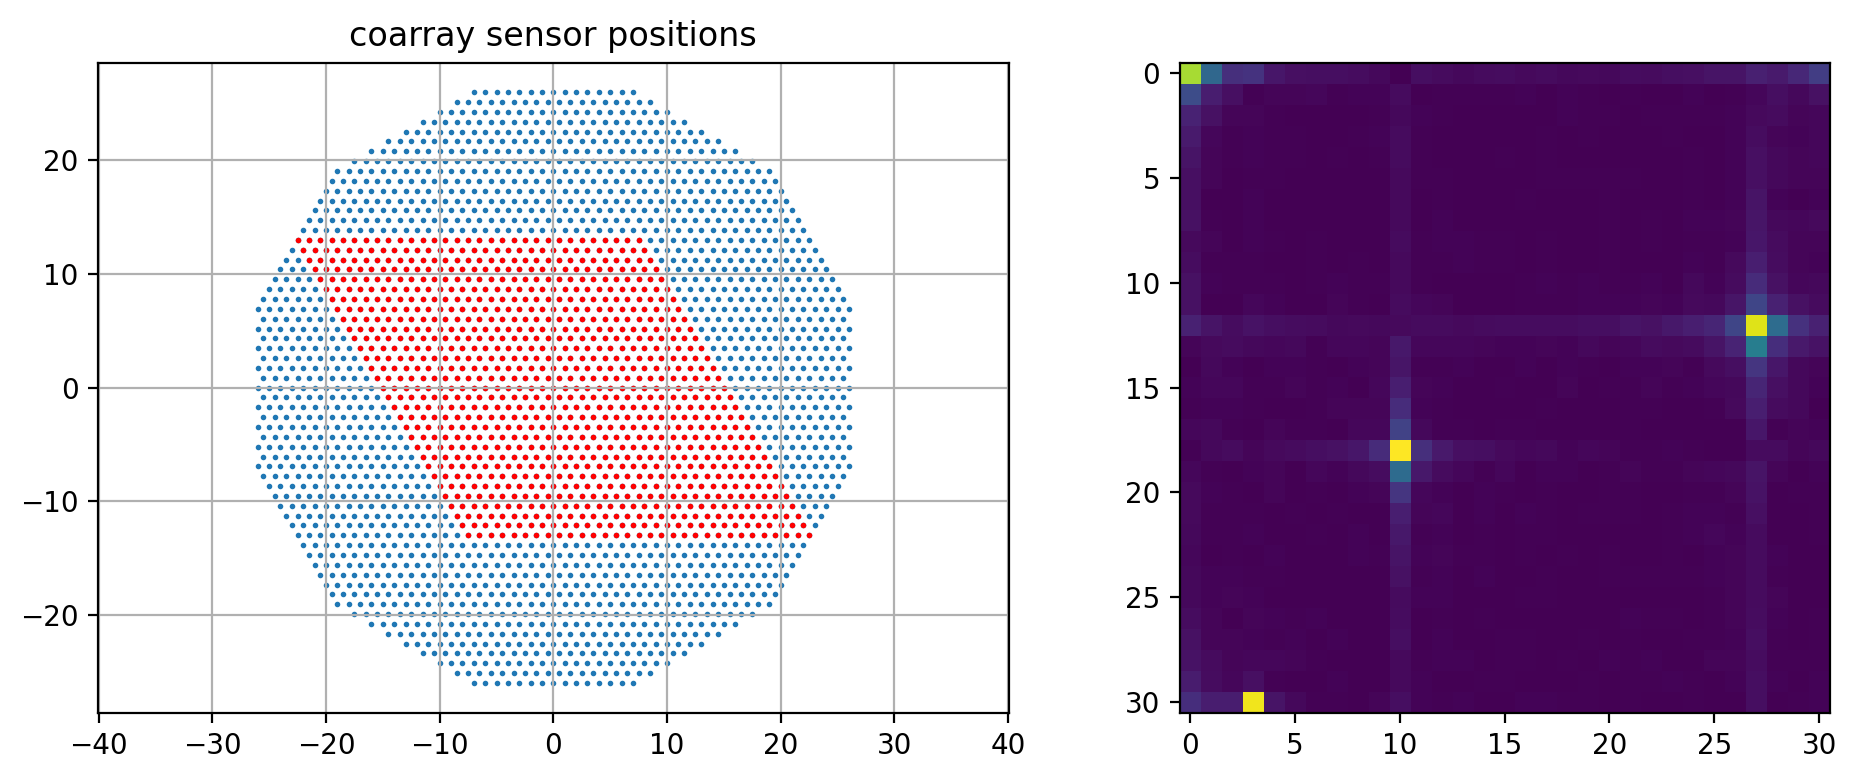

In [254]:
pos_lattice_coarray_set_0_120, sx_0_120, sy_0_120 = get_parallelogram((1, 0), (-1, 1))
pos_lattice_coarray_0_120 = np.array(list(pos_lattice_coarray_set_0_120))
pos_coarray_0_120 = pos_lattice_coarray_0_120 @ shear.T

fft_0_120 = get_fft(pos_lattice_coarray_set_0_120, sx_0_120, sy_0_120)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# first subplot
axes[0].scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
axes[0].scatter(pos_coarray_0_120[:, 0], pos_coarray_0_120[:, 1], s=1, color='red')
axes[0].set_title('coarray sensor positions')
axes[0].axis('equal')
axes[0].grid(True)

# second subplot 
axes[1].imshow(fft_0_120)

# Improve layout
plt.tight_layout()
plt.show()


top_peaks_0_120 = find_peaks(fft_0_120, nbPeaks=nbSources)
results_0_120 = recover_angles_from_peaks(top_peaks=top_peaks_0_120, sx=sx_0_120, sy=sy_0_120, d_lamda_ratio=d_lamda_ratio, phi_ref_2=0, phi_ref_1=2*np.pi/3)

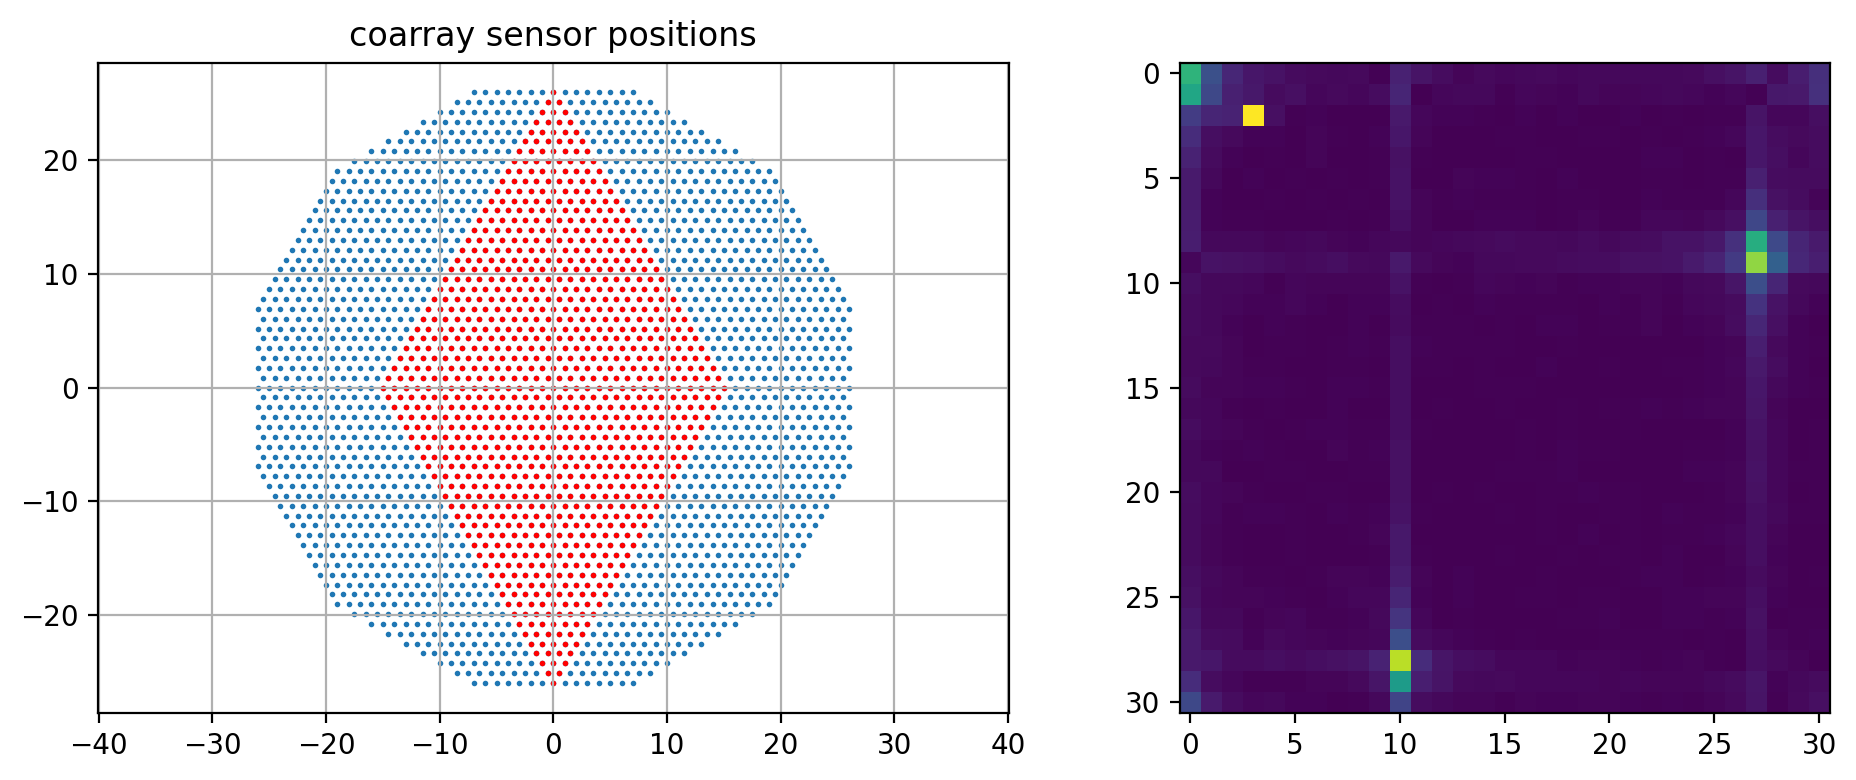

In [256]:
pos_lattice_coarray_set_60_120, sx_60_120, sy_60_120 = get_parallelogram((0, 1), (-1, 1))
pos_lattice_coarray_60_120 = np.array(list(pos_lattice_coarray_set_60_120))
pos_coarray_60_120 = pos_lattice_coarray_60_120 @ shear.T

fft_60_120 = get_fft(pos_lattice_coarray_set_60_120, sx_60_120, sy_60_120)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# first subplot
axes[0].scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
axes[0].scatter(pos_coarray_60_120[:, 0], pos_coarray_60_120[:, 1], s=1, color='red')
axes[0].set_title('coarray sensor positions')
axes[0].axis('equal')
axes[0].grid(True)

# second subplot 
axes[1].imshow(fft_60_120)

# Improve layout
plt.tight_layout()
plt.show()


top_peaks_60_120 = find_peaks(fft_60_120, nbPeaks=nbSources)
results_60_120 = recover_angles_from_peaks(top_peaks=top_peaks_60_120, sx=sx_0_60, sy=sy_60_120, d_lamda_ratio=d_lamda_ratio, phi_ref_2=np.pi/3, phi_ref_1=2*np.pi/3)

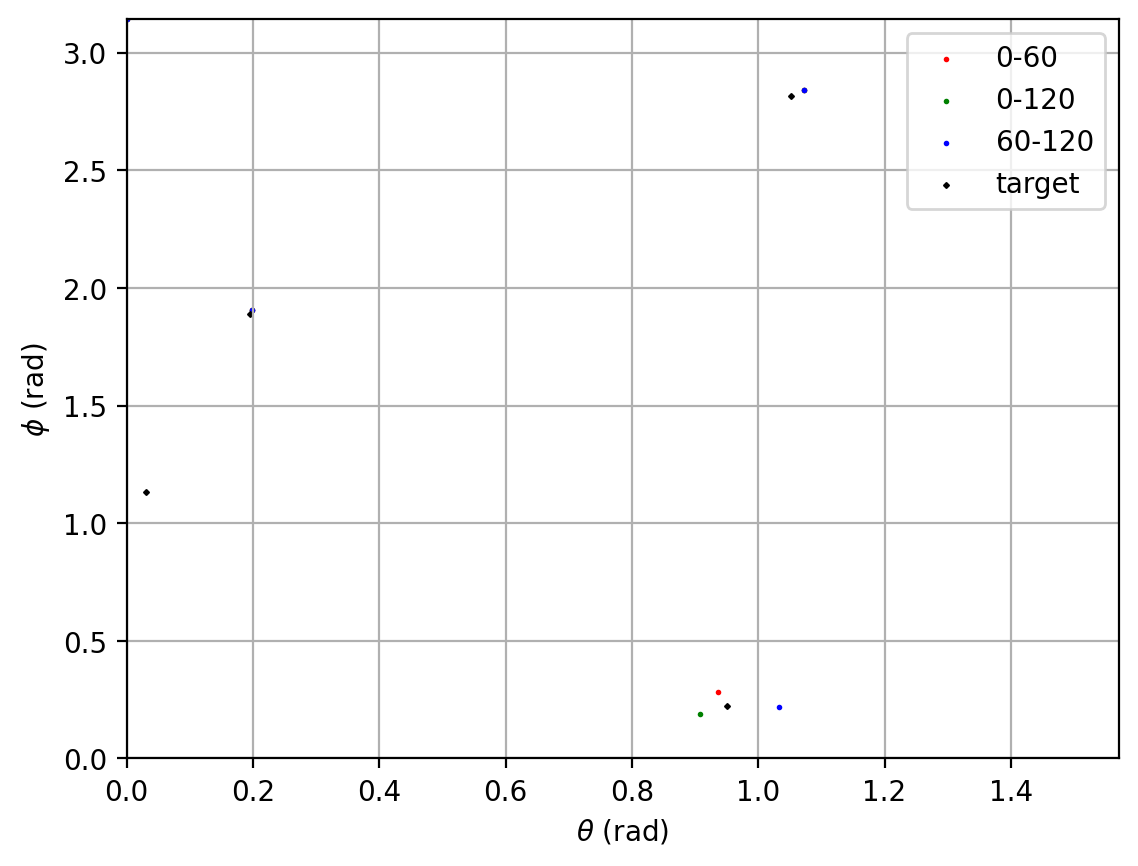

In [257]:
plt.scatter(results_0_60[:, 0], results_0_60[:, 1], color='red', s=1, label='0-60')
plt.scatter(results_0_120[:, 0], results_0_120[:, 1], color='green', s=1, label='0-120')
plt.scatter(results_60_120[:, 0], results_60_120[:, 1], color='blue', s=1, label='60-120')
plt.scatter(theta, phi, marker='x', color='black', s=2, label='target')

plt.xlim(0, np.pi / 2) 
plt.ylim(0, np.pi)  

plt.xlabel(r'$\theta$ (rad)')
plt.ylabel(r'$\phi$ (rad)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
